In [0]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

In [0]:
from google.colab import files
uploaded = files.upload()

Saving invoice_batch2_27.png to invoice_batch2_27.png


In [0]:
#!wget 'https://www.dropbox.com/s/r2ingd0l3zt8hxs/frozen_east_text_detection.tar.gz?dl=1'
#!tar -xvzf frozen_east_text_detection.tar.gz*
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

In [0]:
#im = cv2.imread("2019-07-19-110745_1366x768_scrot.png")
#im = im[20:-20,935:-15]
im = plt.imread("invoice_batch1_47.jpg")
#im = im[50:,:-50]
newW = im.shape[1]//32*32
newH = im.shape[0]//32*32
im_res = cv2.resize(im, (newW, newH))
(inpHeight, inpWidth) = im_res.shape[:2]

In [0]:
confThreshold = .5
nmsThreshold = .5
min_confidence = 0;

blob = cv2.dnn.blobFromImage(im_res, 1.0, (inpWidth, inpHeight), (123.68, 116.78, 103.94), swapRB=True, crop=False)

outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")

net.setInput(blob)
output = net.forward(outputLayers)


scores = output[0]
geometry = output[1]
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < min_confidence:
			continue
 
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
 
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
 
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
 
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
 
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])
    
[boxes, confidences] = decode(scores, geometry, confThreshold)
indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold,nmsThreshold)   

rW = im.shape[1] / float(im_res.shape[1])
rH = im.shape[0] / float(im_res.shape[0])
for i in indices:
    # get 4 corners of the rotated rect
    vertices = cv2.boxPoints(boxes[i[0]])
    # scale the bounding box coordinates based on the respective ratios
    for j in range(4):
        vertices[j][0] *= rW
        vertices[j][1] *= rH
    for j in range(4):
        p1 = (vertices[j][0], vertices[j][1])
        p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
        cv2.line(im, p1, p2, (0, 255, 0), 2, cv2.LINE_AA)
        # cv.putText(frame, "{:.3f}".format(confidences[i[0]]), (vertices[0][0], vertices[0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv.LINE_AA)

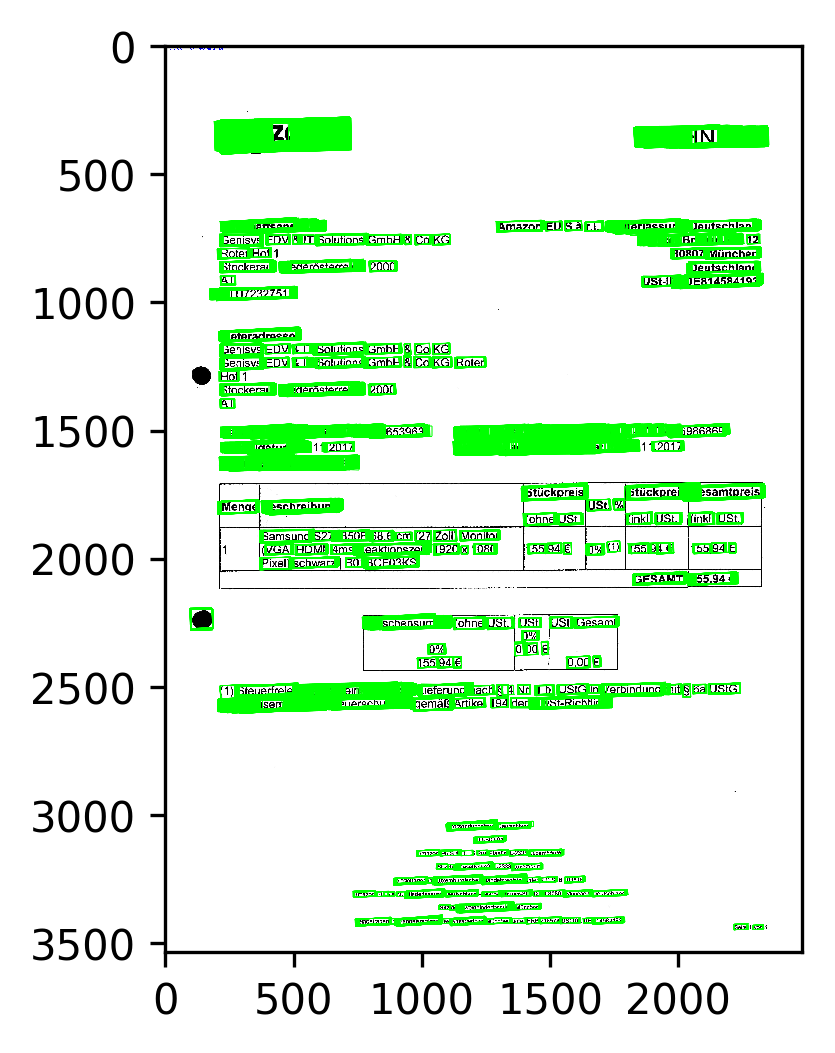

In [0]:
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
        
# Put efficiency information
cv2.putText(im, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

# Display the frame
plt.figure(dpi=300)
plt.imshow(im)

In [0]:
def decode(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if(score < scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
            detections.append((center, (w,h), -1*angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]


In [0]:
im = cv2.imread("HUD_PostFlop_PFR.png",0)
im = im[50:,:-50]
ret,thresh = cv2.threshold(im,127,255,0)
_, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP , cv2.CHAIN_APPROX_SIMPLE)
backtorgb = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
a=cv2.drawContours(backtorgb, contours, -1, (255, 0, 0), 4) 
plt.figure(dpi=300)
plt.imshow(a)
  
